# MADE. RL and Advanced DL.
## Assignment 1.
### RL in Blackjack.
#### Otabek Nazarov

In [1]:
# Imports

import numpy as np
import random
from collections import defaultdict

import Blackjack

import matplotlib.pyplot as plt

import pdb
import sys

In [2]:
env = Blackjack.BlackjackEnv()

## Part 1. Blackjack and Strategies.

### Part 1.1. Stand if [19, 20 or 21] else hit.

Simple strategy of hitting unless we have on hand 19, 20 or 21.

In [18]:
def simple_stand_hit_episode(env):
    # Deal the cards
    p_score, _, done = env.reset()
    
    # Hit until we don't have more than 18
    while (not done):
        states, reward, done, _ = env.step(1)
        p_score, _, _ = states

        if p_score > 18: 
            break

    # End the game and get the reward
    _, reward, _, _ = env.step(0)
    
    return reward

def run_experiments(env, strategy, n_iter=100000):
    rewards = []
    
    # Run n_iter number of experiments
    for _ in range(n_iter):
        rewards.append(strategy(env))
    
    return np.mean(rewards)

In [19]:
stand_hit_avg_reward = run_experiments(env, simple_stand_hit_episode, n_iter=100000)

In [20]:
print(f'Average reward of hitting unless getting 19, 20 or 21: {stand_hit_avg_reward:.3f}')

Average reward of hitting unless getting 19, 20 or 21: -0.223


### Part 1.2. Q-learning.

Below is the implementation of Q-learning algorithm for the game of blackjack.

In [3]:
def q_value_action_double(q_function, state, epsilon, max_action=2):
    """ Function to pick the best action """

    # Randomly initialize state, action values if not present
    if state not in q_function:
        q_function[state] = np.zeros(max_action)
    
    # Pick the best action and its value
    random_action_prob = random.choices([0, 1], [epsilon, 1 - epsilon])

    if (random_action_prob):
        action = int(np.argmax(q_function[state]))
    else:
        action = np.random.randint(0, max_action)
    # action = int(np.argmax(q_function[state]))
    q_value = q_function[state][action]
    
    return q_value, action


def q_learning(env, lr=0.95, gamma=0, n_iter=1000000, info_freq=40000, mean_update_freq=15000, max_action=2, count=False):
    # Initialize variables
    q_function = {} # State : [action1_reward, action2_reward]
    
    mean_rewards = []
    cur_mean_reward = 0

    eps_min = 0.01
    eps_decay =.999965
    epsilon = 1.0

    # Initialize the game
    done = 0
    episode_reward = 0
    init_state = env.reset(count)

    for iter_num in range(n_iter):
        
        while not done:
            epsilon = max(epsilon*eps_decay, eps_min)
            # Choose action for a given state
            q_value, init_action = q_value_action_double(q_function, init_state, epsilon)

            # Perform the step and get state info
            new_state, reward, done, _ = env.step(init_action, count)
            episode_reward = episode_reward + reward


            # Update q function value
            next_q_value, _ = q_value_action_double(q_function, new_state, epsilon)
            q_function[init_state][init_action] = (1 - lr) * q_value + lr * (reward + gamma * next_q_value)

            # Update the state
            init_state = new_state

        # Reinitialize the game
        cur_mean_reward = (iter_num * cur_mean_reward + episode_reward) / (iter_num + 1)
        mean_rewards.append(cur_mean_reward)
        init_state = env.reset(count)
        done = 0
        episode_reward = 0

        # Print the current average reward value
        if (iter_num % info_freq) == 0:
            print(f'Average reward at iteration {iter_num}: {cur_mean_reward}')

    return mean_rewards

To pick hyperparameters I ran grid seach with the parameters: gammas = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8] and learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]. I got the best result when using gamma of 0.1 and learning_rate of 0.02.

In [8]:
# Run Q-learning algorithm and get the average rewards list
q_learning_simple_rewards = q_learning(env, n_iter=2000000, lr=0.02, gamma=0.01, max_action=2, info_freq=50000)

Average reward at iteration 0: -1.0
Average reward at iteration 50000: -0.06487870242595094
Average reward at iteration 100000: -0.061979380206197726
Average reward at iteration 150000: -0.06169958866940875
Average reward at iteration 200000: -0.058504707476462525
Average reward at iteration 250000: -0.05721577113691538
Average reward at iteration 300000: -0.0565564781450728
Average reward at iteration 350000: -0.05635698183719471
Average reward at iteration 400000: -0.05727485681285793
Average reward at iteration 450000: -0.05667987404472431
Average reward at iteration 500000: -0.05693588612822771
Average reward at iteration 550000: -0.056425351953905516
Average reward at iteration 600000: -0.05648657252237959
Average reward at iteration 650000: -0.05630914413977867
Average reward at iteration 700000: -0.05616563404909461
Average reward at iteration 750000: -0.05581059225254403
Average reward at iteration 800000: -0.055576180529774685
Average reward at iteration 850000: -0.05525405264

Observations:<br>
- for the training I chose small learning rate and set high number of iterations. Small learning rate ensures that learning goes in more stable manner without much turbulence. 
- for gamma I chose small value because the episodes blackjack are short and very often the next best state will give a negative reward and in some rare cases it will give positive feedback. Hence, having small gamma makes sure that future values don't strongly affect the current q values. <br>
- I added decaying epsilon greedy exploration. In the beginning it will be choosing random actions more often and over time it will converge towards deterministic decision with very small level of exploration

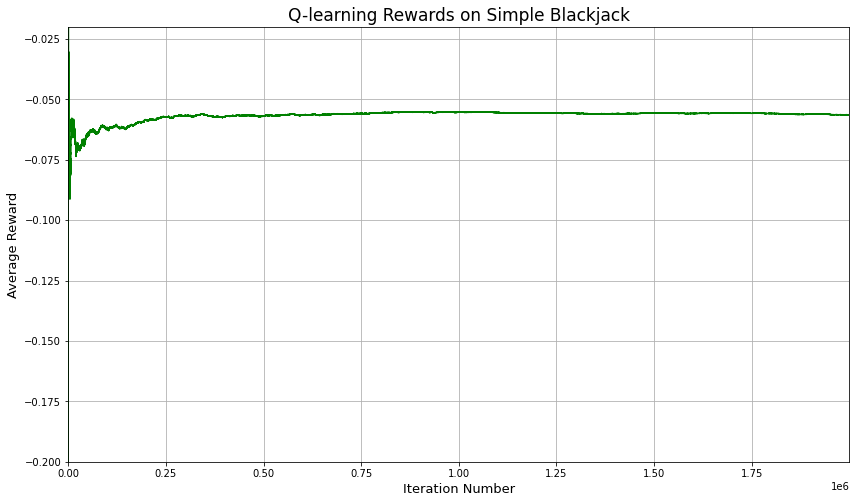

In [16]:
iterations=np.arange(0, len(q_learning_simple_rewards))

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.grid(None)
ax.plot(iterations, q_learning_simple_rewards, color="g")
ax.set_xlim((iterations[0], iterations[-1]))
ax.set_ylim((-0.2, -0.02))
ax.set_xlabel('Iteration Number', fontsize=13)
ax.set_ylabel('Average Reward', fontsize=13)
_ = ax.set_title('Q-learning Rewards on Simple Blackjack', fontsize=17)

## Part 2. Double.

In this section now the player has an option to take one extra card and double his rewards or losses based on the results. The results of training the model are below. In the Blackjack.py file I added the third action of taking one more card and doubling the action. <br>

To pick hyperparameters I ran grid seach with the parameters: gammas = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8] and learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]. I got the best result when using gamma of 0.1 and learning_rate of 0.02.

In [14]:
# Run Q-learning algorithm and get the average rewards list
q_learning_double_rewards = q_learning(env, n_iter=2000000, lr=0.02, gamma=0.1, max_action=3, info_freq=50000)

Average reward at iteration 0: -1.0
Average reward at iteration 50000: -0.06781864362712729
Average reward at iteration 100000: -0.06356936430635635
Average reward at iteration 150000: -0.06203958640275636
Average reward at iteration 200000: -0.06017969910150345
Average reward at iteration 250000: -0.0594397622409502
Average reward at iteration 300000: -0.058316472278424986
Average reward at iteration 350000: -0.058071262653534635
Average reward at iteration 400000: -0.05779985550036069
Average reward at iteration 450000: -0.05723098393114632
Average reward at iteration 500000: -0.056737886524226504
Average reward at iteration 550000: -0.056358079348946
Average reward at iteration 600000: -0.05641657263904514
Average reward at iteration 650000: -0.0561614520593041
Average reward at iteration 700000: -0.055695634720521435
Average reward at iteration 750000: -0.055477259363653816
Average reward at iteration 800000: -0.05510118112352325
Average reward at iteration 850000: -0.0548858177813

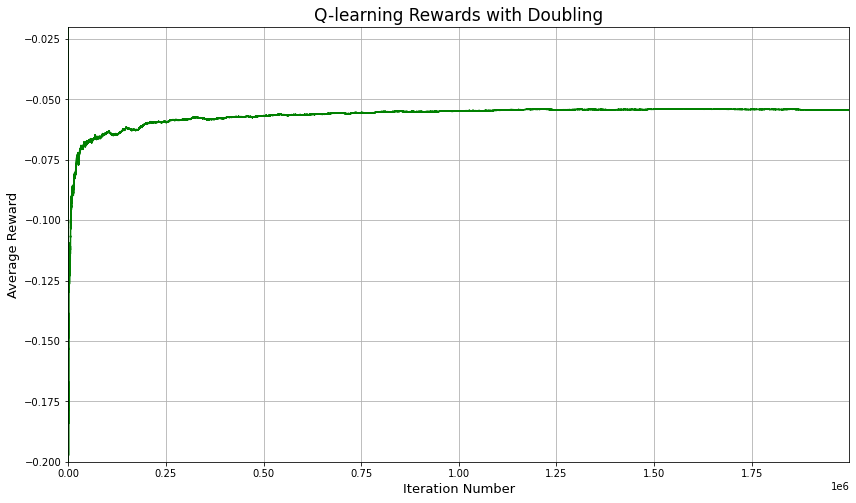

In [15]:
iterations=np.arange(0, len(q_learning_double_rewards))

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.grid(None)
ax.plot(iterations, q_learning_double_rewards, color="g")
ax.set_xlim((iterations[0], iterations[-1]))
ax.set_ylim((-0.2, -0.02))
ax.set_xlabel('Iteration Number', fontsize=13)
ax.set_ylabel('Average Reward', fontsize=13)
_ = ax.set_title('Q-learning Rewards with Doubling', fontsize=17)

Observations: <br>
- increasing gamma helped because in case of doubling future rewards can be higher and accounting for that is important
- doubling helped a bit, but no significant changes are observed

## Part 3. Counting.

To add the counting I used the blackjack card counting system from wikipedia article about blackjack. Each card has its own score (see below). The total score of the deck must be tracked and depending on the total score, player can make a more optimal decision regarding his actions. When the score is positive, the chance of player winning rises, and when it is negative it falls. <br>

To implement this, I modified the state of Blackjack class to account for current score. I added function **def _get_obs_with_count(self)** that returns the score inside the state.  I increased number of decks to three and I restart the score and reshuffle the cards once number of cards reaches 15. 

![alt text](card_counts.png "Title")

Consequently number of states increases. Hence, we will need to train for longer number of iteration for the model to converge to an optimal solution. <br>

To pick hyperparameters I rad grid seach with the parameters: gammas = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8] and learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8]. I got the best result when using gamma of 0.01 and learning_rate of 0.05

In [10]:
# Run Q-learning algorithm and get the average rewards list
q_learning_counting_rewards = q_learning(env, n_iter=20000000, lr=0.02, gamma=0.1, max_action=3, count=True, info_freq=400000)

Average reward at iteration 0: -1.0
Average reward at iteration 400000: -0.07806730483173854
Average reward at iteration 800000: -0.06753366558291747
Average reward at iteration 1200000: -0.06289244758962693
Average reward at iteration 1600000: -0.05976308764807041
Average reward at iteration 2000000: -0.05785847107076462
Average reward at iteration 2400000: -0.05653080977882962
Average reward at iteration 2800000: -0.055359265943119615
Average reward at iteration 3200000: -0.05448373297383372
Average reward at iteration 3600000: -0.05378304061582229
Average reward at iteration 4000000: -0.053052736736816035
Average reward at iteration 4400000: -0.052624306221748775
Average reward at iteration 4800000: -0.05219728079223227
Average reward at iteration 5200000: -0.05191325924744989
Average reward at iteration 5600000: -0.0515276693700588
Average reward at iteration 6000000: -0.05118532480244564
Average reward at iteration 6400000: -0.05082280455893658
Average reward at iteration 6800000:

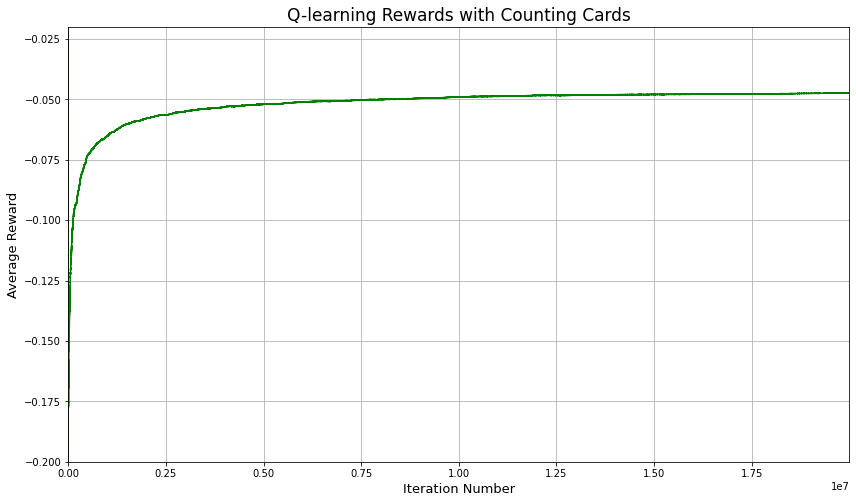

In [11]:
iterations=np.arange(0, len(q_learning_counting_rewards))

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.grid(None)
ax.plot(iterations, q_learning_counting_rewards, color="g")
ax.set_xlim((iterations[0], iterations[-1]))
ax.set_ylim((-0.2, -0.02))
ax.set_xlabel('Iteration Number', fontsize=13)
ax.set_ylabel('Average Reward', fontsize=13)
_ = ax.set_title('Q-learning Rewards with Counting Cards', fontsize=17)

Observations: <br>
- counting improves the rewards results
- it requires longer training iterations because now with counting we have many more states and it takes time to learn them
- it has different training dynamic compared to previous results, previously we would reach consistent average reward pretty quickly but with counting convergence takes much more time; model could continue training, it didn't converge yet
- correct hyperparameters are needed to see the improvement in the score